<a id='sec0'></a>
# Basic Analysis of Word Frequencies
- <a href='#sec1'>Create classified datasets</a>
- <a href='#sec2'>Basic Frequency Analysis</a>
- <a href='#sec3'>Check its classifying capabilities</a>
- <a href='#sec4'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import json
import mskcc_functions as ski
import scipy.stats as scs
import feature_engineering as fe
import csv
import xgboost as xgb

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from collections import Counter
from importlib import reload
from gensim import corpora, matutils, models, similarities
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Using TensorFlow backend.
/usr/lib64/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
Slow version of gensim.models.doc2vec is being used


In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])

<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<ipython-input-2-4467bb76c423>:2: DeprecationWarning: invalid escape sequence \|
  text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',


In [3]:
train = class_train.merge(text_train, on='ID')

<a id='sec1'></a>
# Create classified datasets (<a href='#sec0'>Back to top</a>)

<b>Work Flow</b>
1. Create "classified_docs to" hold all the docs (str) in each class
2. Convert each doc in each class to a list of words with tokenizer
3. Remove special character-containing words and stop words from each word_list in each class
4. Apply stemmer to each word in each word_list in each class


- classified_docs : dictionary<br>
    keys are class labels. values a lists, each of which contains strings from each 'Text' entry in train table
- classified_tokenized_docs : dictionary<br>
    keys are class labels. values are lists of lists. Inner list is a list of words from each 'Text' entry in train table

In [4]:
# create class label container
class_labels = []
for i in range(9):
    class_labels.append('class' + str(i+1))

In [4]:
%%time
# Make a stemmer object, define stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# create classified_docs
classified_docs = {}
classified_tokenized_docs = {}
for i in range(9):
    print('%s being processed...' % class_labels[i])
    docs = [doc for j, doc in enumerate(train[train.Class == (i+1)]['Text'])]
    classified_docs[class_labels[i]] = docs
    
    tokenized_docs = []
    for k, doc in enumerate(docs):
        # tokenize the doc (DO NOT MAKE IT A SET FOR LATER USE)
        tokenized_doc = word_tokenize(fe.replace_with_whitespace(doc, hyphens='on'))

        # Remove stop words and words with special characters
        tokenized_doc = [word for word in tokenized_doc \
                         if re.search(r'^[A-Za-z]', word) \
                         if re.search(r'[A-Za-z0-9]$', word) \
                         if not re.search(r'[@#%&*()+=]', word) \
                         if len(word) > 1 \
                         if word.lower() not in stop_words]

        # Apply stemmer to each word in the list
        tokenized_doc = [stemmer.stem(word) for word in tokenized_doc]
        
        tokenized_docs.append(tokenized_doc)
    
    classified_tokenized_docs[class_labels[i]] = tokenized_docs

class1 being processed...
class2 being processed...
class3 being processed...
class4 being processed...
class5 being processed...
class6 being processed...
class7 being processed...
class8 being processed...
class9 being processed...
CPU times: user 7min 45s, sys: 381 ms, total: 7min 45s
Wall time: 7min 46s


In [5]:
for i in range(9):
    len_docs = len(classified_docs[class_labels[i]])
    len_tokenized_docs = len(classified_tokenized_docs[class_labels[i]])
    print('%s check: ' % class_labels[i], (len_docs == len_tokenized_docs))

class1 check:  True
class2 check:  True
class3 check:  True
class4 check:  True
class5 check:  True
class6 check:  True
class7 check:  True
class8 check:  True
class9 check:  True


<b>Create combined big text for each class</b>

- classified_texts : dictionary<br>
    keys are class labels. values are strings made by combining all the strings from 'Text' entries in each class in train table
- classified_tokenized_texts : dictionary<br>
    keys are class labels. values are lists of words in the combined strings from 'Text' entries in each class in train table
The latter is processed the same way as non-combined dictionary above (i.e. classified_tokenized_docs)

In [6]:
%%time
classified_texts = {}
classified_tokenized_texts = {}
for i in range(9):
    print('%s being processed...' % class_labels[i])
    docs = [doc for doc in train[train.Class == (i+1)]['Text']]
    text = ''
    for doc in docs:
        text = text + doc + ' '
    
    tokenized_text = word_tokenize(fe.replace_with_whitespace(text, hyphens='on'))
    tokenized_text = [word for word in tokenized_text \
                         if re.search(r'^[A-Za-z]', word) \
                         if re.search(r'[A-Za-z0-9]$', word) \
                         if not re.search(r'[@#%&*()+=]', word) \
                         if len(word) > 1 \
                         if word.lower() not in stop_words]
    tokenized_text = [stemmer.stem(word) for word in tokenized_text]
    
    classified_texts[class_labels[i]] = text
    classified_tokenized_texts[class_labels[i]] = tokenized_text

class1 being processed...
class2 being processed...
class3 being processed...
class4 being processed...
class5 being processed...
class6 being processed...
class7 being processed...
class8 being processed...
class9 being processed...
CPU times: user 8min 6s, sys: 27.9 s, total: 8min 34s
Wall time: 8min 35s


<b>Save dictionaries for later use</b>

In [7]:
with open('./data/classified_docs.json', 'w') as f1:
    json.dump(classified_docs, f1)

with open('./data/classified_tokenized_docs.json', 'w') as f2:
    json.dump(classified_tokenized_docs, f2)

with open('./data/classified_texts.json', 'w') as f3:
    json.dump(classified_texts, f3)

with open('./data/classified_tokenized_texts.json', 'w') as f4:
    json.dump(classified_tokenized_texts, f4)

<a id='sec2'></a>
# Basic Frequency Analysis  (<a href='#sec0'>Back to top</a>)

<b>average per-doc appearance & appearance frequency (num_docs with the word / total_num_docs)</b>

\*Use dictionaries and pandas
- Create a list of unique words for each class
- Average per-doc appearances
  Count number of appearances per document and average over number of documents in each class
- Appearance frequency (num_docs with the word / total_num_docs)
  Check if a word appearcs in a document or not, and calculate the fraction of documents that contain the word   for each class

In [8]:
classified_unique_sets = {}
for i in range(9):
    tokenized_text = classified_tokenized_texts[class_labels[i]]
    unique_set = list(set(tokenized_text))
    classified_unique_sets[class_labels[i]] = unique_set
    print('# of unique words in %s: %d'% (class_labels[i], len(unique_set)))

# of unique words in class1: 50671
# of unique words in class2: 42200
# of unique words in class3: 9331
# of unique words in class4: 41992
# of unique words in class5: 17022
# of unique words in class6: 19101
# of unique words in class7: 64771
# of unique words in class8: 7881
# of unique words in class9: 8949


In [9]:
%%time
ave_perdoc_apps = {}
app_freqs = {}
for i in range(9):
    print('%s being processed...' % class_labels[i])
    tokenized_docs = classified_tokenized_docs[class_labels[i]]
    num_docs = len(tokenized_docs)
    
    tokenized_text = classified_tokenized_texts[class_labels[i]]
    c = Counter(tokenized_text)
    ave_perdoc_app = dict(c)
    ave_perdoc_app = {key:(value/num_docs) for key, value in ave_perdoc_app.items()}
    
    app_freq_list = []
    for doc in tokenized_docs:
        c = Counter(doc)
        freq = dict(c)
        app_freq = {key:1 for key, value in freq.items() if value > 0}
        app_freq_list.append(app_freq)
    app_freq_table = pd.DataFrame(app_freq_list)
    app_freq = dict(app_freq_table.sum(axis=0)/num_docs)
    
    ave_perdoc_apps[class_labels[i]] = ave_perdoc_app
    app_freqs[class_labels[i]] = app_freq

class1 being processed...
class2 being processed...
class3 being processed...
class4 being processed...
class5 being processed...
class6 being processed...
class7 being processed...
class8 being processed...
class9 being processed...
CPU times: user 28.3 s, sys: 424 ms, total: 28.7 s
Wall time: 28.7 s


In [10]:
with open('./data/average_per_document_appearances.json', 'w') as f5:
    json.dump(ave_perdoc_apps, f5)
    
with open('./data/fraction_of_documents_with_appearance.json', 'w') as f6:
    json.dump(app_freqs, f6)

<b>Reload the dictionaries from json files</b>

In [5]:
with open('./data/classified_docs.json') as f1:
    classified_docs = json.load(f1)

with open('./data/classified_tokenized_docs.json') as f2:
    classified_tokenized_docs = json.load(f2)

with open('./data/classified_texts.json') as f3:
    classified_texts = json.load(f3)

with open('./data/classified_tokenized_texts.json') as f4:
    classified_tokenized_texts = json.load(f4)

with open('./data/average_per_document_appearances.json') as f5:
    ave_perdoc_apps = json.load(f5)
    
with open('./data/fraction_of_documents_with_appearance.json') as f6:
    app_freqs = json.load(f6)

<b>Remove frequent words that appear in >50% of docs in each class</b>

- Get top 3000 words in terms of fraction of documents that they appear within each class
- Make a set for intersection of above words among all classes
- Remove words in the set if they appear in more than 50% of the documents in each class

In [6]:
%%time
fracdocs = pd.DataFrame(app_freqs).fillna(value=0)
n = 3000

top_words = []
for i in range(9):
    tops = fracdocs[class_labels[i]].sort_values(ascending=False).head(n)
    top_words.append(list(tops.index))

overlap1 = set(top_words[0])
for lis in top_words[1:]:
    overlap1.intersection_update(lis)
print('# intersecting words among top%d appearing words in each class: ', len(overlap1))
    
remove_list = []
for i in range(9):
    remove_words = [word for word in overlap1 \
                    if word in fracdocs[class_labels[i]] \
                    if fracdocs[class_labels[i]][word] > 0.5]
    remove_list.append(list(remove_words))

overlap2 = set(remove_list[0])
for lis in remove_list[1:]:
    overlap2.intersection_update(lis)
print('# intersecting words with >50% appearance: ', len(overlap2))

fracdocs_update1 = fracdocs.copy()
fracdocs_update1 = fracdocs_update1.drop(overlap2)
print('Table shape before removal: ', fracdocs.shape)
print('Table shape after removal:  ', fracdocs_update1.shape)

# intersecting words among top%d appearing words in each class:  1391
# intersecting words with >50% appearance:  287
Table shape before removal:  (125448, 9)
Table shape after removal:   (125161, 9)
CPU times: user 623 ms, sys: 6.91 ms, total: 630 ms
Wall time: 630 ms


<b>n-class appearance words</b>

Get words whose appearance frequency is more than 0.5 higher in n-classes than in the other classes

In [7]:
def get_FoldDifference(a, b, freq_threshold=0.05, default_return=50):
    if ((b != 0) and (a >= freq_threshold)):
        return (a / b)
    elif ((b == 0) and (a >= freq_threshold)):
        return default_return
    else:
        return 0

def get_nClassWords(docs, fold_threshold, freq_threshold, print_result=True):

    fold_th = fold_threshold
    freq_th = freq_threshold

    ncw_labels = ['one_class_words', 'two_class_words', 'three_class_words', 
                  'four_class_words', 'five_class_words', 'six_class_words', 
                  'seven_class_words', 'eight_class_words','other_words']

    # Create a new dictionary to contain each n-class of words in list formats
    n_class_words = {}
    for i in range(9):
        n_class_words[ncw_labels[i]] = []

    # Get words for each n-class of words (might be a better way to do this?)

    for j, word in enumerate(docs.index):
        apps = np.array(docs.loc[word])
        apps[::-1].sort()
        #print(apps)
        if get_FoldDifference(apps[0], apps[1], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[0]].append(word)
        elif get_FoldDifference(apps[1], apps[2], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[1]].append(word)
        elif get_FoldDifference(apps[2], apps[3], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[2]].append(word)
        elif get_FoldDifference(apps[3], apps[4], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[3]].append(word)
        elif get_FoldDifference(apps[4], apps[5], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[4]].append(word)
        elif get_FoldDifference(apps[5], apps[6], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[5]].append(word)
        elif get_FoldDifference(apps[6], apps[7], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[6]].append(word)
        elif get_FoldDifference(apps[7], apps[8], freq_threshold=freq_th) >= fold_th:
            n_class_words[ncw_labels[7]].append(word)
        else:
            n_class_words[ncw_labels[8]].append(word)
    
    one_class_remove_list = ['bunkyo', 'commonest', 'commonplac', 'concret', 'consol','conspicu', 'credenc', 
                         'damage—unlik', 'drew', 'enumer', 'graduat','ibaraki', 'joshi', 'kaneda', 
                         'kurumizaka', 'lesson', 'logo', 'matsui', 'minami', 'minato', 'montreal', 'newyork', 
                         'ontario', 'shirokanedai', 'sinai', 'taipei', 'wake', 'wise', 'yokohama']
    n_class_words['one_class_words'] = [word for word in n_class_words['one_class_words'] if len(word) > 2]
    
    if print_result:
        print('======== n-class words extractions ========')
        print('Fold Threshold = %f' % fold_th)
        print('Frequency Threshold = %f' % freq_th)
        total = 0
        for i in range(9):
            print('# of words in %s: %d' % (ncw_labels[i], len(n_class_words[ncw_labels[i]])))
            total += len(n_class_words[ncw_labels[i]])
        print('Total # of words: %d' % total)
    
    return n_class_words

In [8]:
%%time
fold_threshold = 1.3
freq_threshold = 0.35
n_class_words = get_nClassWords(fracdocs_update1, fold_threshold, freq_threshold)

======== n-class words extractions ========
Fold Threshold = 1.300000
Frequency Threshold = 0.350000
# of words in one_class_words: 421
# of words in two_class_words: 150
# of words in three_class_words: 25
# of words in four_class_words: 24
# of words in five_class_words: 17
# of words in six_class_words: 20
# of words in seven_class_words: 46
# of words in eight_class_words: 78
# of words in other_words: 124364
Total # of words: 125145
CPU times: user 9.35 s, sys: 4.74 ms, total: 9.36 s
Wall time: 9.36 s


<a id='sec3'></a>
# Check its classifying capabilities (<a href='#sec0'>Back to top</a>)

<b>First, prepare un-classified tokenized documents</b>

This had to be done instead of importing previous ones because this time I used stemmer

In [12]:
%%time
# Make a stemmer object, define stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

unclassified_tokenized_docs = []
for i in range(len(text_train)):
    doc= text_train['Text'].iloc[i]
    tokenized_doc = word_tokenize(fe.replace_with_whitespace(doc, hyphens='on'))
    
    # Remove stop words and words with special characters
    tokenized_doc = [word for word in tokenized_doc \
                     if re.search(r'^[A-Za-z]', word) \
                     if re.search(r'[A-Za-z0-9]$', word) \
                     if not re.search(r'[@#%&*()+=]', word) \
                     if len(word) > 1 \
                     if word.lower() not in stop_words]
    
    # Apply stemmer to each word in the list
    tokenized_doc = [stemmer.stem(word) for word in tokenized_doc]

    unclassified_tokenized_docs.append(tokenized_doc)

print('# of docs tokenized: %d' % len(unclassified_tokenized_docs))

# of docs tokenized: 3321
CPU times: user 7min 38s, sys: 350 ms, total: 7min 38s
Wall time: 7min 39s


In [27]:
with open("./data/unclassified_tokenized_docs.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(unclassified_tokenized_docs)

<b>Play with thresholds</b>

In [9]:
# Read in the saved unclassified tokenized documents
with open("./data/unclassified_tokenized_docs.csv", "r") as f:
    reader = csv.reader(f)
    unclassified_tokenized_docs = list(reader)

one-class words

In [16]:
%%time
accuracies = []
log_losses = []

thresholds = [[1.5, 0.4], [1.45, 0.4], [1.4, 0.4], [1.35, 0.4], [1.3, 0.4], [1.25, 0.4],
              [1.4, 0.5], [1.4, 0.45], [1.4, 0.4], [1.4, 0.35], [1.4, 0.3], [1.4, 0.25]]

for i in range(len(thresholds)):
    n_class_words = get_nClassWords(fold_threshold=thresholds[i][0], freq_threshold=thresholds[i][1], print_result=False)
    picked_class_words = n_class_words['one_class_words']

    # Use one_class_words as dictionary
    my_dict = corpora.Dictionary([picked_class_words])

    corpus = [my_dict.doc2bow(doc) for doc in unclassified_tokenized_docs]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(picked_class_words), num_docs=len(corpus_tfidf)).T

    X = np.array(feature_matrix).astype(float)
    y = np.array(class_train.Class).astype(int).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    # Run RFC on the data
    rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=6, random_state=33)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba, labels=list(range(1, 10)))
    accuracies.append(accuracy)
    log_losses.append(loss)
    
    print('Iteration %d: thresholds (%f, %f)' % ((i+1), thresholds[i][0], thresholds[i][1]))
    print(' - Picked class words total: %d' % len(picked_class_words))
    print(' - Accuracyl: %f' % accuracy)
    print(' - Log Loss: %f' % loss)

Iteration 1: thresholds (1.500000, 0.400000)
 - Picked class words total: 161
 - Accuracyl: 0.649299
 - Log Loss: 1.452549
Iteration 2: thresholds (1.450000, 0.400000)
 - Picked class words total: 186
 - Accuracyl: 0.595190
 - Log Loss: 2.054217
Iteration 3: thresholds (1.400000, 0.400000)
 - Picked class words total: 210
 - Accuracyl: 0.643287
 - Log Loss: 1.612364
Iteration 4: thresholds (1.350000, 0.400000)
 - Picked class words total: 257
 - Accuracyl: 0.623246
 - Log Loss: 1.985838
Iteration 5: thresholds (1.300000, 0.400000)
 - Picked class words total: 291
 - Accuracyl: 0.661323
 - Log Loss: 1.622760
Iteration 6: thresholds (1.250000, 0.400000)
 - Picked class words total: 360
 - Accuracyl: 0.655311
 - Log Loss: 1.661119
Iteration 7: thresholds (1.400000, 0.500000)
 - Picked class words total: 105
 - Accuracyl: 0.629259
 - Log Loss: 1.696014
Iteration 8: thresholds (1.400000, 0.450000)
 - Picked class words total: 146
 - Accuracyl: 0.611222
 - Log Loss: 1.672723
Iteration 9: thr

Two class words

In [17]:
%%time
accuracies = []
log_losses = []

thresholds = [[1.5, 0.4], [1.45, 0.4], [1.4, 0.4], [1.35, 0.4], [1.3, 0.4], [1.25, 0.4],
              [1.4, 0.5], [1.4, 0.45], [1.4, 0.4], [1.4, 0.35], [1.4, 0.3], [1.4, 0.25]]

for i in range(len(thresholds)):
    n_class_words = get_nClassWords(fold_threshold=thresholds[i][0], freq_threshold=thresholds[i][1], print_result=False)
    picked_class_words = n_class_words['one_class_words'] + n_class_words['two_class_words']

    # Use one_class_words as dictionary
    my_dict = corpora.Dictionary([picked_class_words])

    corpus = [my_dict.doc2bow(doc) for doc in unclassified_tokenized_docs]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(picked_class_words), num_docs=len(corpus_tfidf)).T

    X = np.array(feature_matrix).astype(float)
    y = np.array(class_train.Class).astype(int).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    # Run RFC on the data
    rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=6, random_state=33)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba, labels=list(range(1, 10)))
    accuracies.append(accuracy)
    log_losses.append(loss)
    
    print('Iteration %d: thresholds (%f, %f)' % ((i+1), thresholds[i][0], thresholds[i][1]))
    print(' - Picked class words total: %d' % len(picked_class_words))
    print(' - Accuracyl: %f' % accuracy)
    print(' - Log Loss: %f' % loss) 

Iteration 1: thresholds (1.500000, 0.400000)
 - Picked class words total: 227
 - Accuracyl: 0.609218
 - Log Loss: 1.980705
Iteration 2: thresholds (1.450000, 0.400000)
 - Picked class words total: 257
 - Accuracyl: 0.593186
 - Log Loss: 1.996262
Iteration 3: thresholds (1.400000, 0.400000)
 - Picked class words total: 292
 - Accuracyl: 0.615230
 - Log Loss: 2.026499
Iteration 4: thresholds (1.350000, 0.400000)
 - Picked class words total: 348
 - Accuracyl: 0.653307
 - Log Loss: 1.511065
Iteration 5: thresholds (1.300000, 0.400000)
 - Picked class words total: 398
 - Accuracyl: 0.613226
 - Log Loss: 1.576266
Iteration 6: thresholds (1.250000, 0.400000)
 - Picked class words total: 482
 - Accuracyl: 0.627255
 - Log Loss: 1.851047
Iteration 7: thresholds (1.400000, 0.500000)
 - Picked class words total: 138
 - Accuracyl: 0.629259
 - Log Loss: 1.814755
Iteration 8: thresholds (1.400000, 0.450000)
 - Picked class words total: 194
 - Accuracyl: 0.625251
 - Log Loss: 1.879969
Iteration 9: thr

Three class words

In [32]:
%%time
accuracies = []
log_losses = []

thresholds = [[1.5, 0.4], [1.45, 0.4], [1.4, 0.4], [1.35, 0.4], [1.3, 0.4], [1.25, 0.4],
              [1.4, 0.5], [1.4, 0.45], [1.4, 0.4], [1.4, 0.35], [1.4, 0.3], [1.4, 0.25]]

for i in range(len(thresholds)):
    n_class_words = get_nClassWords(fold_threshold=thresholds[i][0], freq_threshold=thresholds[i][1], print_result=False)
    picked_class_words = n_class_words['one_class_words'] + n_class_words['two_class_words'] + n_class_words['three_class_words']

    # Use one_class_words as dictionary
    my_dict = corpora.Dictionary([picked_class_words])

    corpus = [my_dict.doc2bow(doc) for doc in unclassified_tokenized_docs]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(picked_class_words), num_docs=len(corpus_tfidf)).T

    X = np.array(feature_matrix).astype(float)
    y = np.array(class_train.Class).astype(int).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    # Run RFC on the data
    rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=100, n_jobs=6, random_state=33)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba, labels=list(range(1, 10)))
    accuracies.append(accuracy)
    log_losses.append(loss)
    
    print('Iteration %d: thresholds (%f, %f)' % ((i+1), thresholds[i][0], thresholds[i][1]))
    print(' - Picked class words total: %d' % len(picked_class_words))
    print(' - Accuracyl: %f' % accuracy)
    print(' - Log Loss: %f' % loss) 

Iteration 1: thresholds (1.500000, 0.400000)
 - Picked class words total: 233
 - Accuracyl: 0.605210
 - Log Loss: 1.609186
Iteration 2: thresholds (1.450000, 0.400000)
 - Picked class words total: 264
 - Accuracyl: 0.647295
 - Log Loss: 1.524966
Iteration 3: thresholds (1.400000, 0.400000)
 - Picked class words total: 302
 - Accuracyl: 0.627255
 - Log Loss: 2.058454
Iteration 4: thresholds (1.350000, 0.400000)
 - Picked class words total: 361
 - Accuracyl: 0.641283
 - Log Loss: 1.844839
Iteration 5: thresholds (1.300000, 0.400000)
 - Picked class words total: 416
 - Accuracyl: 0.639279
 - Log Loss: 1.756952
Iteration 6: thresholds (1.250000, 0.400000)
 - Picked class words total: 503
 - Accuracyl: 0.629259
 - Log Loss: 1.572570
Iteration 7: thresholds (1.400000, 0.500000)
 - Picked class words total: 139
 - Accuracyl: 0.639279
 - Log Loss: 1.924031
Iteration 8: thresholds (1.400000, 0.450000)
 - Picked class words total: 198
 - Accuracyl: 0.641283
 - Log Loss: 1.387314
Iteration 9: thr

(3321, 479)
0.691382765531
1.45375335909


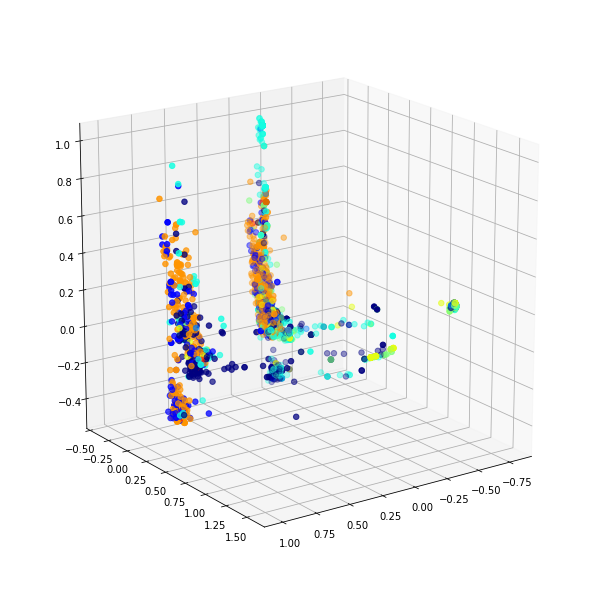

In [66]:
thresholds = (1.400000, 0.450000)

n_class_words = get_nClassWords(fold_threshold=thresholds[0], freq_threshold=thresholds[1], print_result=False)
picked_class_words = n_class_words['one_class_words'] + n_class_words['two_class_words'] + n_class_words['three_class_words']

# Use one_class_words as dictionary
my_dict = corpora.Dictionary([picked_class_words])

corpus = [my_dict.doc2bow(doc) for doc in unclassified_tokenized_docs]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(picked_class_words), num_docs=len(corpus_tfidf)).T
feat1 = pd.DataFrame(feature_matrix)

# Import Data and extract gene and mutation type info
# Get Gene feature from 'train_variants' data
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
gene_table = pd.DataFrame(X_gene_bin)

# Get Mutation Type from 'train_variants' data
mut_type = ski.convert_mutation_type(class_train)
X_mtype = np.array(mut_type['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
mtype_table = pd.DataFrame(X_mtype_bin)

features = pd.concat([gene_table, mtype_table, feat1], axis=1)
print(features.shape)

X = np.array(features).astype(float)
y = np.array(class_train.Class).astype(int).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Run RFC on the data
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=6, random_state=33)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print(accuracy_score(y_test, y_pred))
print(log_loss(y_test, y_proba, labels=list(range(1, 10))))

# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=5)
pca.fit(X)
pca_table1['x1'] = pca.fit_transform(X).T[0]
pca_table1['x2'] = pca.fit_transform(X).T[1]
pca_table1['x3'] = pca.fit_transform(X).T[2]
pca_table1['x4'] = pca.fit_transform(X).T[3]
pca_table1['x5'] = pca.fit_transform(X).T[4]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table1.x1, pca_table1.x2, pca_table1.x3, c=class_train['Class'], marker = 'o', s=30, cmap = cm.jet)

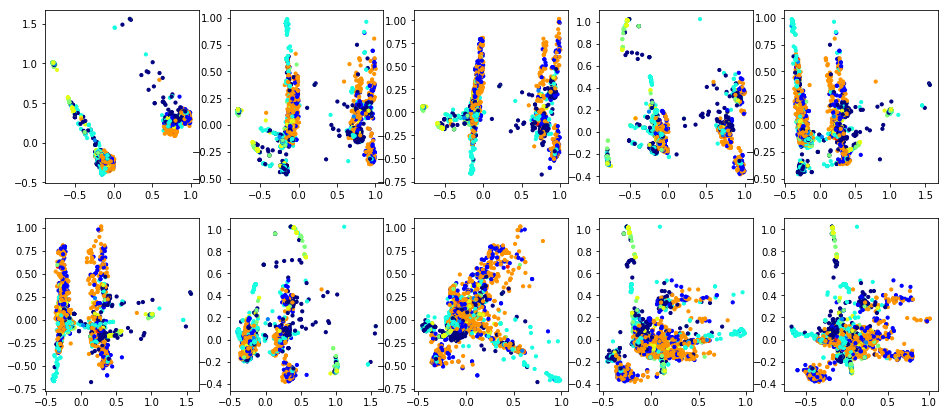

In [67]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2,5, figsize=(16,7))
ax1.scatter(pca_table1.x1, pca_table1.x2, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax2.scatter(pca_table1.x1, pca_table1.x3, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax3.scatter(pca_table1.x1, pca_table1.x4, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax4.scatter(pca_table1.x1, pca_table1.x5, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax5.scatter(pca_table1.x2, pca_table1.x3, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax6.scatter(pca_table1.x2, pca_table1.x4, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax7.scatter(pca_table1.x2, pca_table1.x5, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax8.scatter(pca_table1.x3, pca_table1.x4, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax9.scatter(pca_table1.x3, pca_table1.x5, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)
ax10.scatter(pca_table1.x4, pca_table1.x5, c=class_train['Class'], marker = 'o', s=10, cmap = cm.jet)

<b>Try another way of vectorizing</b>

In [14]:
%%time
accuracies = []
log_losses = []

thresholds = [(1.25, 0.4)]#[[1.5, 0.4], [1.45, 0.4], [1.4, 0.4], [1.35, 0.4], [1.3, 0.4], [1.25, 0.4], 
              #[1.4, 0.5], [1.4, 0.45], [1.4, 0.4], [1.4, 0.35], [1.4, 0.3], [1.4, 0.25]]

for i in range(len(thresholds)):

    # Remove all other words from each doc
    n_class_words = get_nClassWords(fold_threshold=thresholds[i][0], freq_threshold=thresholds[i][1], print_result=False)
    picked_class_words = n_class_words['one_class_words'] + n_class_words['two_class_words'] + n_class_words['three_class_words']
    
    unclf_docs2 = []
    for j, doc in enumerate(unclassified_tokenized_docs):
        doc = [word for word in doc if word in picked_class_words]
        text = ' '.join(doc)
        unclf_docs2.append(text)

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unclf_docs2).toarray()

    X = X.astype(float)
    y = np.array(class_train.Class).astype(int).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    # Run RFC on the data
    rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=6, random_state=33)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba, labels=list(range(1, 10)))
    accuracies.append(accuracy)
    log_losses.append(loss)
    
    print('Iteration %d/%d: thresholds (%.3f, %.3f)' % ((i+1), len(thresholds), thresholds[i][0], thresholds[i][1]))
    print(' - Picked class words total: %d' % len(picked_class_words))
    print(' - Accuracyl: %.3f' % accuracy)
    print(' - Log Loss: %.3f' % loss)

print('Max Accuracy: %.3f' % np.max(accuracies))
print('Min Log Loss: %.3f' % np.min(log_losses))

Iteration 1/1: thresholds (1.250, 0.400)
 - Picked class words total: 503
 - Accuracyl: 0.679
 - Log Loss: 1.512
Max Accuracy: 0.679
Min Log Loss: 1.512
CPU times: user 1min 52s, sys: 35.2 ms, total: 1min 52s
Wall time: 1min 51s


In [10]:
%%time
# Get other stuff
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
gene_table = pd.DataFrame(X_gene_bin)

mut_type = ski.convert_mutation_type(class_train)
X_mtype = np.array(mut_type['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
mtype_table = pd.DataFrame(X_mtype_bin)

CPU times: user 213 ms, sys: 3.02 ms, total: 216 ms
Wall time: 224 ms


In [11]:
%%time
accuracies = []
log_losses = []

thresholds = [(1.25, 0.4)]#[[1.5, 0.4], [1.45, 0.4], [1.4, 0.4], [1.35, 0.4], [1.3, 0.4], [1.25, 0.4], 
              #[1.4, 0.5], [1.4, 0.45], [1.4, 0.4], [1.4, 0.35], [1.4, 0.3], [1.4, 0.25]]

for i in range(len(thresholds)):

    # Remove all other words from each doc
    n_class_words = get_nClassWords(fracdocs_update1, fold_threshold=thresholds[i][0], freq_threshold=thresholds[i][1], print_result=False)
    picked_class_words = n_class_words['one_class_words'] + n_class_words['two_class_words'] + n_class_words['three_class_words']
    
    unclf_docs2 = []
    for j, doc in enumerate(unclassified_tokenized_docs):
        doc = [word for word in doc if word in picked_class_words]
        text = ' '.join(doc)
        unclf_docs2.append(text)
    print('Processing text complete...')
    
    vectorizer = CountVectorizer()
    feat1 = vectorizer.fit_transform(unclf_docs2).toarray()
    feat1 = pd.DataFrame(feat1)
    print('Vectorization text complete...')
    
    print('Splitting datasets...')
    features = pd.concat([gene_table, mtype_table, feat1], axis=1)
    X = np.array(features).astype(float)
    y = np.array(class_train.Class).astype(int).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    
    # Run RFC on the data
    print('Training the classifier...')
    rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=7, random_state=33)
    rfc.fit(X_train, y_train)
    
    print('Making predictions...')
    y_pred = rfc.predict(X_test)
    y_proba = rfc.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba, labels=list(range(1, 10)))
    accuracies.append(accuracy)
    log_losses.append(loss)
    
    print('Iteration %d/%d: thresholds (%.3f, %.3f)' % ((i+1), len(thresholds), thresholds[i][0], thresholds[i][1]))
    print(' - Picked class words total: %d' % len(picked_class_words))
    print(' - Accuracyl: %.3f' % accuracy)
    print(' - Log Loss: %.3f' % loss)

print('Max Accuracy: %.3f' % np.max(accuracies))
print('Min Log Loss: %.3f' % np.min(log_losses))

Iteration 1/1: thresholds (1.250, 0.400)
 - Picked class words total: 503
 - Accuracyl: 0.661
 - Log Loss: 1.777
Max Accuracy: 0.661
Min Log Loss: 1.777
CPU times: user 1min 54s, sys: 40.5 ms, total: 1min 54s
Wall time: 1min 53s


With Multinomial Naive Bayes

In [33]:
%%time
accuracies = []
log_losses = []

thresholds = [(1.25, 0.4)] #[[1.5, 0.4], [1.45, 0.4], [1.4, 0.4], [1.35, 0.4], [1.3, 0.4], [1.25, 0.4], 
              #[1.4, 0.5], [1.4, 0.45], [1.4, 0.4], [1.4, 0.35], [1.4, 0.3], [1.4, 0.25]]

for i in range(len(thresholds)):

    # Remove all other words from each doc
    n_class_words = get_nClassWords(fold_threshold=thresholds[i][0], freq_threshold=thresholds[i][1], print_result=False)
    picked_class_words = n_class_words['one_class_words'] + n_class_words['two_class_words'] + n_class_words['three_class_words']
    
    unclf_docs2 = []
    for j, doc in enumerate(unclassified_tokenized_docs):
        doc = [word for word in doc if word in picked_class_words]
        text = ' '.join(doc)
        unclf_docs2.append(text)

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unclf_docs2).toarray()

    X = X.astype(float)
    y = np.array(class_train.Class).astype(int).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    # Run RFC on the data
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_proba, labels=list(range(1, 10)))
    accuracies.append(accuracy)
    log_losses.append(loss)
    
    print('Iteration %d/%d: thresholds (%.3f, %.3f)' % ((i+1), len(thresholds), thresholds[i][0], thresholds[i][1]))
    print(' - Picked class words total: %d' % len(picked_class_words))
    print(' - Accuracyl: %.3f' % accuracy)
    print(' - Log Loss: %.3f' % loss)

print('Max Accuracy: %.3f' % np.max(accuracies))
print('Min Log Loss: %.3f' % np.min(log_losses))

Iteration 1/1: thresholds (1.250, 0.400)
 - Picked class words total: 503
 - Accuracyl: 0.451
 - Log Loss: 14.312
Max Accuracy: 0.451
Min Log Loss: 14.312
CPU times: user 1min 47s, sys: 10.8 ms, total: 1min 47s
Wall time: 1min 47s
